In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = ""
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize
from collections import Counter
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
import nltk
from functools import reduce

# Load PyDrive and Google Auth related packages
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

# Load the json data
def load_json_file(name):
  """
  Load the json file and return a json object
  """
  with open(name,encoding='utf-8') as myfile:
    data = json.load(myfile)
    return data

# Convert json data object to a pandas data frame
def convert_to_pd(data):
  """
  Load the data to a pandas dataframe.
  Dataframe Columns:
    title
    para_index
    context
    q_index
    q_id
    q_isimpossible
    q_question
    q_anscount - number of answers
    q_answers - a list of object e.g [{ text: '', answer_start: 123}, ...]
  """
  result = []
  for pdata in data['data']:
    for para in pdata['paragraphs']:
      for q in para['qas']:
        result.append({
            'title' : pdata['title'],
            'context' : para['context'],
            'q_id' : q['id'],
            'q_isimpossible' : q['is_impossible'],
            'q_question' : q['question'],
            'q_anscount' : len(q['answers']),
            'q_answers' : [a for a in q['answers']],
            'q_answers_text': [a.get("text") for a in q['answers']],
            'context_lowercase': para['context'].lower(),
            'q_question_lowercase' : q['question'].lower(),
            'q_answers_text_lowercase': [a.get("text").lower() for a in q['answers']],
            
        })

  return pd.DataFrame.from_dict(result, orient='columns')

# Load the file from shareable google drive link and return a pandas dataframe
def loadDataFile(filename): 
  """
  Download a file from google drive with the shared link
  """ 
  data = load_json_file(filename)
  return convert_to_pd(data)

In [2]:
train_filename = 'train-v2.0.json'
dev_filename = 'dev-v2.0.json'

train_pd = loadDataFile(train_filename)
dev_pd = loadDataFile(dev_filename)

In [3]:
train_pd

,title,context,q_id,q_isimpossible,q_question,q_anscount,q_answers,q_answers_text,context_lowercase,q_question_lowercase,q_answers_text_lowercase
0,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9063,False,When did Beyonce start becoming popular?,1,"[{'text': 'in the late 1990s', 'answer_start':...",[in the late 1990s],beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ b...,when did beyonce start becoming popular?,[in the late 1990s]
1,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9065,False,What areas did Beyonce compete in when she was...,1,"[{'text': 'singing and dancing', 'answer_start...",[singing and dancing],beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ b...,what areas did beyonce compete in when she was...,[singing and dancing]
2,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56be85543aeaaa14008c9066,False,When did Beyonce leave Destiny's Child and bec...,1,"[{'text': '2003', 'answer_start': 526}]",[2003],beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ b...,when did beyonce leave destiny's child and bec...,[2003]
3,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56bf6b0f3aeaaa14008c9601,False,In what city and state did Beyonce grow up?,1,"[{'text': 'Houston, Texas', 'answer_start': 166}]","[Houston, Texas]",beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ b...,in what city and state did beyonce grow up?,"[houston, texas]"
4,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,56bf6b0f3aeaaa14008c9602,False,In which decade did Beyonce become famous?,1,"[{'text': 'late 1990s', 'answer_start': 276}]",[late 1990s],beyoncé giselle knowles-carter (/biːˈjɒnseɪ/ b...,in which decade did beyonce become famous?,[late 1990s]
...,...,...,...,...,...,...,...,...,...,...,...
130314,Matter,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a875439,True,Physics has broadly agreed on the definition o...,0,[],[],"the term ""matter"" is used throughout physics i...",physics has broadly agreed on the definition o...,[]
130315,Matter,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543a,True,Who coined the term partonic matter?,0,[],[],"the term ""matter"" is used throughout physics i...",who coined the term partonic matter?,[]
130316,Matter,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543b,True,What is another name for anti-matter?,0,[],[],"the term ""matter"" is used throughout physics i...",what is another name for anti-matter?,[]
130317,Matter,"The term ""matter"" is used throughout physics i...",5a7e070b70df9f001a87543c,True,Matter usually does not need to be used in con...,0,[],[],"the term ""matter"" is used throughout physics i...",matter usually does not need to be used in con...,[]


In [3]:
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from functools import reduce
flatten = lambda data: reduce(lambda x, y: x + y, data)
import glove_helper

In [4]:
def get_c_q_a(dataset):
    q_id_list = []
    context_list =[]
    questions_list = []
    answers_list =[]
    q_impossible_list =[]
    for index,row in dataset.iterrows():
        q_id_list.append(row.q_id)
        context_list.append(row.context)
        questions_list.append(row.q_question)
        q_impossible_list.append(int(row.q_isimpossible))
        if len(row.q_answers_text)>0 :
            answers_list.append(row.q_answers_text[0])
        else:
            answers_list.append("")
    return [q_id_list,context_list,questions_list,q_impossible_list,answers_list]
    

In [5]:
train_lists = get_c_q_a(train_pd)
dev_lists = get_c_q_a(dev_pd)


In [6]:
context_maxlen = max(map(len, (x.split() for x in train_lists[1])))
question_maxlen = max(map(len, (x.split() for x in train_lists[2])))
answer_maxlen = max(map(len, (x.split() for x in train_lists[4])))

In [7]:
print("Max context length:",context_maxlen)
print("Max question length:",question_maxlen)
print("Max answer length:",answer_maxlen)

Max context length: 653
Max question length: 40
Max answer length: 43


In [8]:
def tokenize_c_q_a(dataset):
    tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"''",oov_token='<unk>')
    data = dataset[1]+dataset[2]+dataset[4]
    tokenizer.fit_on_texts(data)
    vocab = tokenizer.word_index
    vocab['<s>'] = len(vocab)+1
    vocab['</s>'] = len(vocab)+1
    return (tokenizer,vocab)

In [9]:
#tokenizer_obj = tokenize_c_q_a([a+b for a,b in zip(train_lists,dev_lists)])
tokenizer_obj,vocab = tokenize_c_q_a(train_lists)

In [10]:
vocab_size = len(vocab)
print("Vocab Size:",vocab_size)

Vocab Size: 88701


In [11]:
def vectorize_data(tokenizer_obj,train_lists):
    context_seq = tokenizer_obj.texts_to_sequences(train_lists[1])
    question_seq = tokenizer_obj.texts_to_sequences(train_lists[2])
    answer_seq = tokenizer_obj.texts_to_sequences(train_lists[4])
    answer_input_seq = [[vocab['<s>']]+i for i in answer_seq]
    answer_target_seq = [i+[vocab['</s>']] for i in answer_seq]
    context_seq_padded = pad_sequences(context_seq,context_maxlen,padding='post', truncating='post')
    question_seq_padded = pad_sequences(question_seq,question_maxlen,padding='post', truncating='post')
    answer_seq_padded = pad_sequences(answer_seq,answer_maxlen,padding='post', truncating='post')
    answer_input_seq_padded = pad_sequences(answer_input_seq,answer_maxlen+1,padding='post', truncating='post')
    answer_target_seq_padded = pad_sequences(answer_target_seq,answer_maxlen+1,padding='post', truncating='post')
    answer_impossible = np.array(train_lists[3])
    indices = np.arange(context_seq_padded.shape[0])
    np.random.shuffle(indices)
    context_seq_padded = context_seq_padded[indices]
    question_seq_padded = question_seq_padded[indices]
    answer_seq_padded = answer_seq_padded[indices]
    answer_input_seq_padded = answer_input_seq_padded[indices]
    answer_target_seq_padded = answer_target_seq_padded[indices]
    answer_impossible_shuffled = answer_impossible[indices]
    train_samples = int(context_seq_padded.shape[0]*.8)
    train_context_padded_seq = context_seq_padded[:train_samples]
    train_question_seq_padded = question_seq_padded[:train_samples]
    train_answer_seq_padded = answer_seq_padded[:train_samples]
    train_answer_input_seq_padded = answer_input_seq_padded[:train_samples]
    train_answer_target_seq_padded = answer_target_seq_padded[:train_samples]
    train_answer_impossible = answer_impossible_shuffled[:train_samples]
    val_context_padded_seq = context_seq_padded[train_samples:]
    val_question_seq_padded = question_seq_padded[train_samples:]
    val_answer_seq_padded = answer_seq_padded[train_samples:]
    val_answer_input_seq_padded = answer_input_seq_padded[train_samples:]
    val_answer_target_seq_padded = answer_target_seq_padded[train_samples:]
    val_answer_impossible = answer_impossible_shuffled[train_samples:]
    return (train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,
            train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,
            val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,
            val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible)

In [12]:
train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,\
train_answer_input_seq_padded,train_answer_target_seq_padded,\
train_answer_impossible,\
val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,\
val_answer_input_seq_padded,val_answer_target_seq_padded,\
val_answer_impossible\
= vectorize_data(tokenizer_obj,train_lists)

In [13]:
print(len(val_answer_seq_padded[val_answer_impossible==1]))
print(len(val_answer_seq_padded[val_answer_impossible==0]))
print(len(train_answer_seq_padded[train_answer_impossible==1]))
print(len(train_answer_seq_padded[train_answer_impossible==0]))


8677
17387
34821
69434


In [14]:
def create_embedding_matrix(word_index,vocab_size=50000,ndim=100):
    hands = glove_helper.Hands(ndim)
    embedding_matrix = np.zeros((vocab_size+1,ndim))
    for word,i in word_index.items():
        if i<=vocab_size:
            embedding_vector = hands.get_vector(word,strict=False)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

In [15]:
embedding_matrix = create_embedding_matrix(vocab,vocab_size,100)

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [17]:
class BahdanauAttention(layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V =  layers.Dense(1)

    def call(self, inputs):
        query = inputs[0]
        values = inputs[1]
        #print("query shape",query.shape)
        #print("vaues shape",values.shape)
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        #query_with_time_axis = tf.expand_dims(query, 1)
        #print("query_with_time_axis shape",query_with_time_axis.shape)
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(keras.activations.tanh(
        self.W1(query) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = keras.activations.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        #context_vector = tf.reduce_sum(context_vector, axis=1)
        #print("context vector shape",context_vector.shape)

        return context_vector

def create_memory_using_attention(num_episodes,query,context_outputs,attention_type,BahdanauUnits=32):
    m = layers.Lambda(lambda x: x)(query)
    Dense_Layer_concat_M_q = layers.Dense(units=query.shape[1],activation='tanh')
    if attention_type == 0:
        #use keras attention which is Luong's
        attention_layer = layers.Attention()
    else:
        # use BahdanauAttention
        attention_layer = BahdanauAttention(BahdanauUnits)
    for i in range(num_episodes):
        m_plus_q =layers.concatenate(inputs=[m,query],axis=1)
        if attention_type ==0:
            m_plus_q = Dense_Layer_concat_M_q(m_plus_q)
        m_plus_q_with_time_axis = tf.keras.backend.expand_dims(m_plus_q, 1)
        context_with_attention = attention_layer([m_plus_q_with_time_axis,context_outputs])
        m = tf.keras.backend.sum(context_with_attention, axis=1)
        
    
    return m

In [20]:
tf.config.optimizer.get_experimental_options()

{'arithmetic_optimization': False,
 'dependency_optimization': False,
 'disable_model_pruning': False,
 'pin_to_host_optimization': False,
 'disable_meta_optimizer': True,
 'min_graph_nodes': -1}

In [22]:
tf.config.optimizer.set_experimental_options({'arithmetic_optimization':False,
                                              'dependency_optimization':False,
                                              'pin_to_host_optimization':False,
                                              'min_graph_nodes':-1,
                                            'disable_meta_optimizer':True})
num_unit_gru = 16
num_layers_gru = 1
ndim =100
num_episodes = 1
num_dense_layer_feasibility = 16
dropout_rate = 0.5
num_dense_layers_feasibility = 1
attentionType = 0 # 0 means Luong's 1 means BahdanauUnits
BahdanauUnits = 32
#Input Module
context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
context_embeddings = layers.Embedding(vocab_size+1,ndim,name='Context_Embedding')(context_input)

for i in range(num_layers_gru):
    context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                  recurrent_dropout= dropout_rate,
                                                  return_sequences=True),name='Context_Bid_Layer'+str(i))
    if i==0:
        context_outputs = context_outputs_layers(context_embeddings)
    else:
        context_outputs = context_outputs_layers(context_outputs)
print("Context output shape",context_outputs.shape)
#Question Module
question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
question_embeddings = layers.Embedding(vocab_size+1,ndim,name='Question_Embedding')(question_input)

for i in range(num_layers_gru):
    if i==0 and num_layers_gru >1:
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=True),
                                                name='Question_Bid_Layer'+str(i))(question_embeddings)
    elif i==0 and num_layers_gru ==1:
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=False),
                                                name='Question_Bid_Layer'+str(i))(question_embeddings)
    elif i==(num_layers_gru-1):
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=False),
                                                name='Question_Bid_Layer'+str(i))(question_outputs)
    else:
        question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,dropout=dropout_rate,
                                                recurrent_dropout= dropout_rate,
                                                return_sequences=True),
                                                name='Question_Bid_Layer'+str(i))(question_outputs)
#Episodic Memory Module
m=create_memory_using_attention(num_episodes,question_outputs,context_outputs,attentionType,BahdanauUnits)
print(m.shape)
print(context_outputs.shape)
print(question_outputs.shape)
concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],axis=1)
#feasibility module
for i in range(num_dense_layers_feasibility):
    if i==0:
        dense_layer = layers.Dense(num_dense_layer_feasibility,
                            activation='relu',name='feasibility_layer_'+str(i))(concatenated_tensor)
    else:
        dense_layer = layers.Dense(num_dense_layer_feasibility,
                            activation='relu',name='feasibility_layer_'+str(i))(dense_layer)
    dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

feasibility_output = layers.Dense(1,activation='sigmoid',name='feasibility_output')(dropout_layer)
#answer_module

answer_input = Input(shape=(None,),dtype='int32',name='Answer_Input')
answer_embeddings = layers.Embedding(vocab_size+1,ndim,name='Answer_Embedding')(answer_input)
for i in range(num_layers_gru):
    answer_decoder_layers = layers.GRU(concatenated_tensor.shape[1],dropout=dropout_rate,
                                       recurrent_dropout= dropout_rate,
                                       return_sequences=True,
                                       return_state=True,
                                       name='Answer_GRU_Layer'+str(i)
                                       )
    if i==0:
        answer_outputs,_ = answer_decoder_layers(answer_embeddings,initial_state=concatenated_tensor)
    else:
        answer_outputs,_ = answer_decoder_layers(answer_outputs)

answer_decoder_dense = layers.TimeDistributed(layers.Dense(vocab_size+1, activation='softmax')
                                              ,name='Answer_output')
answer_decoder_outputs = answer_decoder_dense(answer_outputs)

model2 = Model([context_input,question_input,answer_input],[feasibility_output,answer_decoder_outputs])
model2.get_layer("Question_Embedding").set_weights([embedding_matrix])
model2.get_layer("Question_Embedding").trainable = False
model2.get_layer("Context_Embedding").set_weights([embedding_matrix])
model2.get_layer("Context_Embedding").trainable = False
model2.get_layer("Answer_Embedding").set_weights([embedding_matrix])
model2.get_layer("Answer_Embedding").trainable = False

model2.summary()

Context output shape (None, None, 32)
(None, 32)
(None, None, 32)
(None, 32)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Question_Input (InputLayer)     [(None, None)]       0                                            
__________________________________________________________________________________________________
Question_Embedding (Embedding)  (None, None, 100)    8870200     Question_Input[0][0]             
__________________________________________________________________________________________________
Question_Bid_Layer0 (Bidirectio (None, 32)           11328       Question_Embedding[0][0]         
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 32)           0           Question_Bid_Layer0[0][0]        
_______________

In [ ]:
#rmsprop_optim = keras.optimizers.RMSprop(clipnorm=1.0)
model2.compile(optimizer='adam',
             loss=[tf.keras.losses.BinaryCrossentropy()
,tf.keras.losses.SparseCategoricalCrossentropy()],
             metrics=['acc'],
             loss_weights=[0.1,0.9])
history = model2.fit({'Context_Input':train_context_padded_seq[:800],
                     'Question_Input':train_question_seq_padded[:800],
                     'Answer_Input':train_answer_input_seq_padded[:800]},
                    {'feasibility_output':train_answer_impossible[:800],
                    'Answer_output':train_answer_target_seq_padded[:800]},
                    epochs=3,batch_size=10)

Train on 800 samples
Epoch 1/3
310/800 [==========>...................] - ETA: 1:29 - loss: 10.2051 - feasibility_output_loss: 0.7044 - Answer_output_loss: 11.2607 - feasibility_output_acc: 0.5355 - Answer_output_acc: 0.8852

In [72]:
model2.predict({'Context_Input':train_context_padded_seq[0:20],
                     'Question_Input':train_question_seq_padded[0:20]})

array([[0.32527226],
       [0.38361147],
       [0.35280904],
       [0.32739577],
       [0.30996448],
       [0.3327996 ],
       [0.31396386],
       [0.3474672 ],
       [0.3205491 ],
       [0.34641057],
       [0.3261181 ],
       [0.34217474],
       [0.35450697],
       [0.337914  ],
       [0.32633847],
       [0.3211355 ],
       [0.318175  ],
       [0.2954424 ],
       [0.32123357],
       [0.35080382]], dtype=float32)

In [73]:
train_answer_impossible[0:20]

array([1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1])

In [40]:
from w266_common import utils
utils.require_package("wget")      # for fetching dataset
utils.require_package("bokeh")     # for plotting histograms
utils.require_package("graphviz")  # for rendering trees
utils.require_package("pydot")

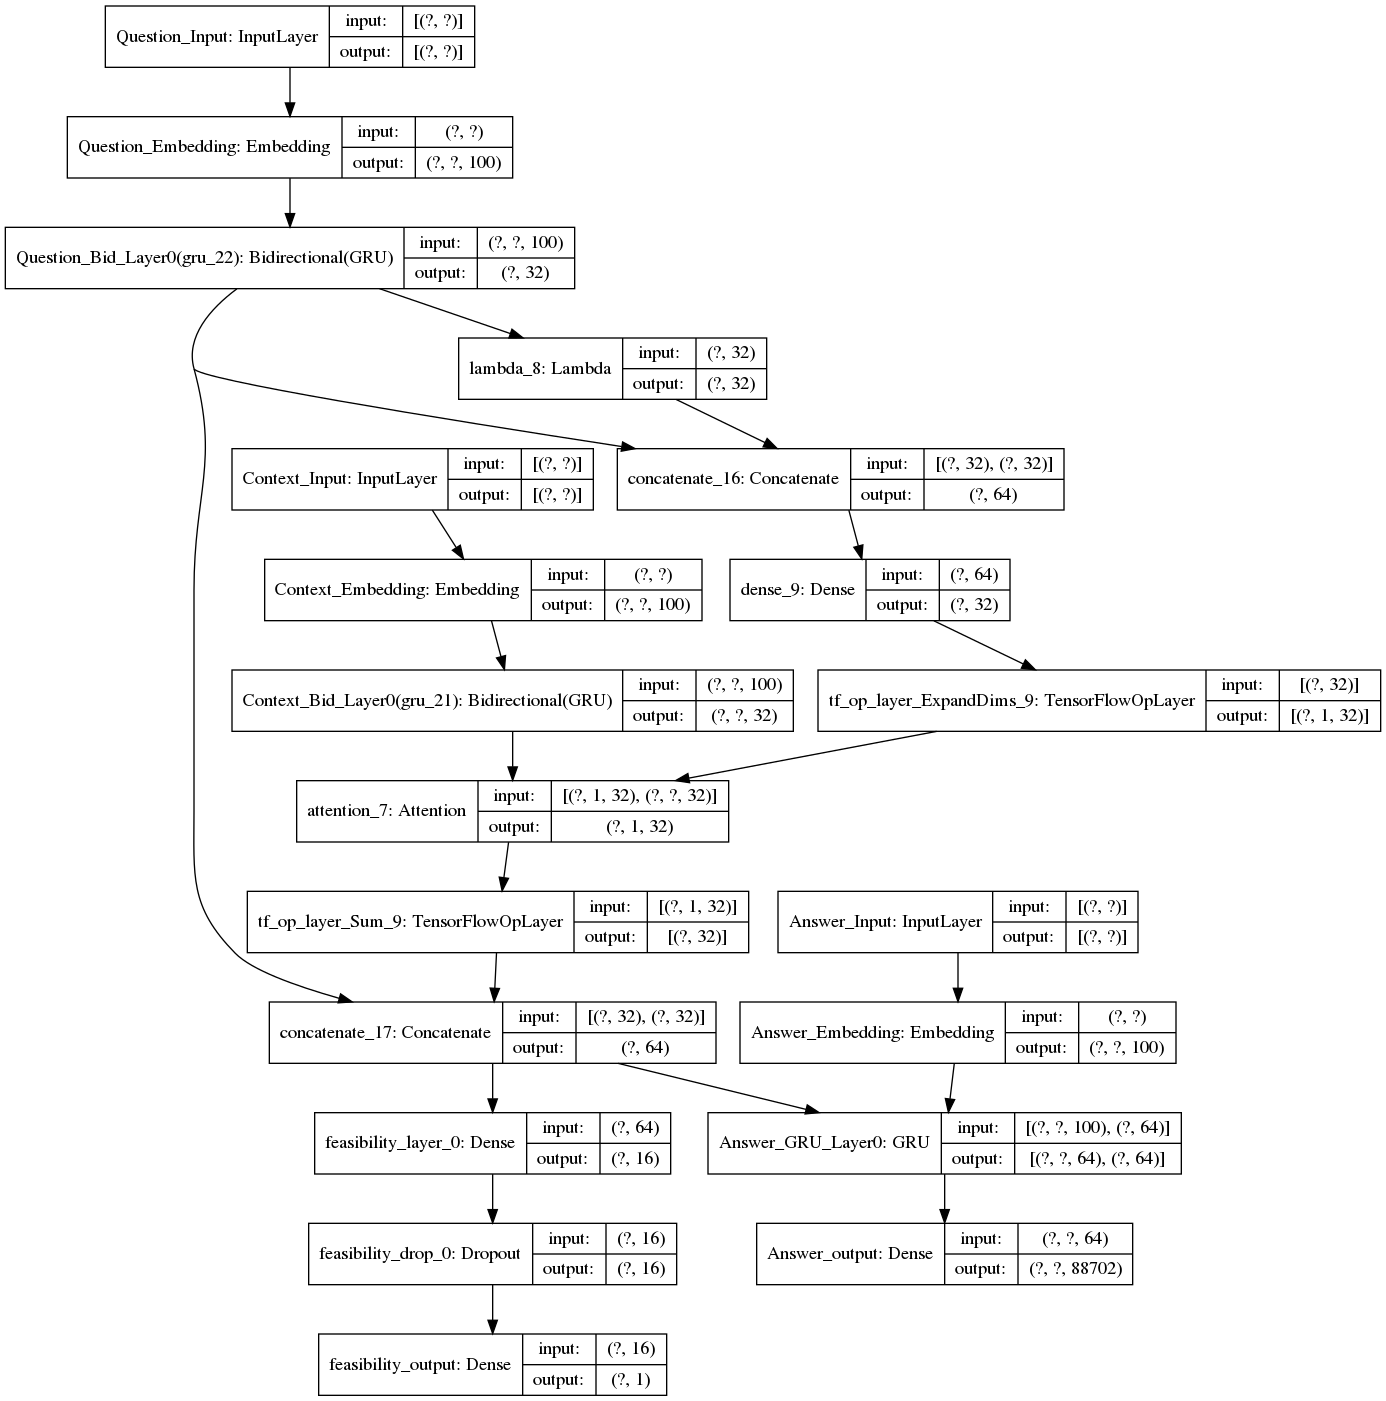

In [49]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(model2,show_shapes=True)